# Project 2
## Modeling
### MVP 

In [14]:
# necessary imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression

from sklearn.model_selection import (cross_val_score, cross_validate, train_test_split, KFold, GridSearchCV)

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV       #ordinary linear regression + w/ ridge'lasso regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


In [15]:
%pwd

'/Users/max/python/github/china_box_office'

In [16]:
mvp_df = pd.read_csv('data/mvp_df.csv')

In [25]:
# imputed nans in budget, release_date_diff and running_time

mvp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   china_total_gross       419 non-null    float64
 1   budget                  419 non-null    float64
 2   running_time            419 non-null    float64
 3   release_order_CN_first  419 non-null    int64  
 4   star_power_sum          419 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 16.5 KB


In [26]:
# establishing features and target

X, y = mvp_df.drop('china_total_gross',axis=1), mvp_df['china_total_gross']

In [27]:
# setting aside holdout data for final testing

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=.2, random_state=17)

In [28]:
#this helps with the way kf will generate indices below

X_train, y_train = np.array(X_train), np.array(y_train)

In [29]:
# establishing 5 cross-validation folds
kf = KFold(n_splits=5, shuffle=True, random_state = 17)

In [31]:
# ADD ARG TO SEE TRAIN SCORE TO COMPARE FOR OVERFTTING
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate

def val_test(features, target):
    lm = LinearRegression()

    scores = cross_validate(lm, features, target, cv=kf, scoring='r2', return_train_score=True)
    print('>>>>',scores['train_score'])
    print(">>>> Linear Reg Mean Train Score: ", np.mean(scores['train_score']),'\n')
    
    print('>>>>',scores['test_score'])
    print(">>>> Linear Reg Mean Test Score: ", np.mean(scores['test_score']))


In [32]:
val_test(X_train, y_train)

>>>> [0.15716807 0.26061903 0.18905755 0.20698783 0.1963077 ]
>>>> Linear Reg Mean Train Score:  0.20202803571009645 

>>>> [ 0.32884092  0.11995895 -0.01056706  0.0483634   0.10322964]
>>>> Linear Reg Mean Test Score:  0.11796516909738194


WOW we're off to a rough start. Will have to work _a lot_ more on feature engineering

#### Visualizing relationships - MVP

In [33]:
lin_reg_est = LinearRegression()

scores = cross_val_score(lin_reg_est, X_train, y_train, cv=kf)
print(scores)
print("Linear Reg Mean Score: ", np.mean(scores))

[ 0.32884092  0.11995895 -0.01056706  0.0483634   0.10322964]
Linear Reg Mean Score:  0.11796516909738194


In [34]:
# Build the Model

lin_reg_est.fit(X_train, y_train);

Text(0, 0.5, 'Residuals')

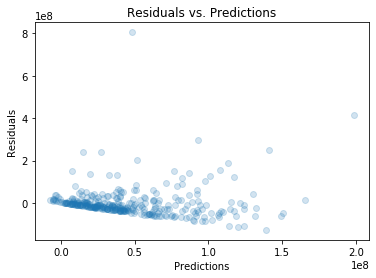

In [185]:
# Fitted vs. Actual

y_train_pred = lin_reg_est.predict(X_train)
resid = y_train - y_train_pred

plt.scatter(y_train_pred, resid, alpha=0.2)
plt.title("Residuals vs. Predictions")
plt.xlabel('Predictions')
plt.ylabel('Residuals')
#plt.savefig('viz/mvp_resid.svg');

#### Budget vs CN Gross - MVP

In [35]:
X_budget = mvp_df.loc[:,"budget"].values.reshape(-1,1)
y = mvp_df.loc[:,"china_total_gross"]

In [36]:
lin_reg_est = LinearRegression()

lin_reg_est.fit(X_budget, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

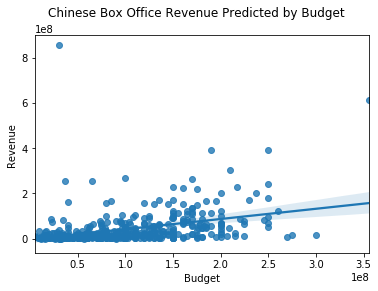

In [37]:
sns.regplot(X_budget, y)
plt.suptitle('Chinese Box Office Revenue Predicted by Budget')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.savefig('viz/mvp_budget.svg')

In [38]:
import scipy.stats as stats

def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

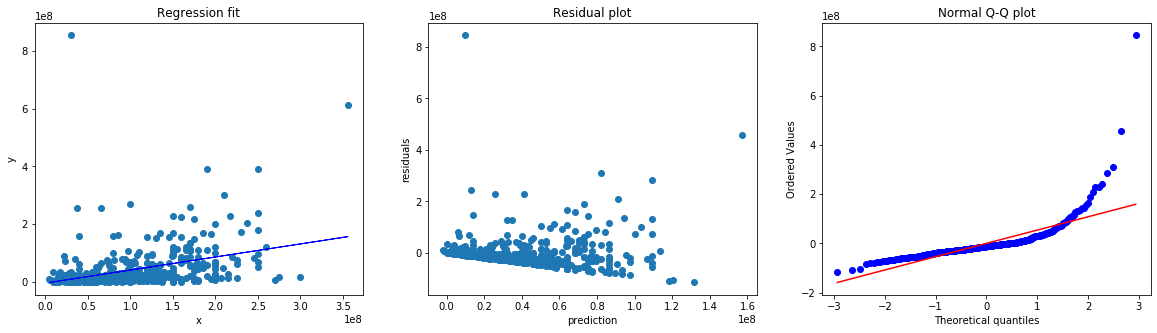

In [39]:
diagnostic_plot(X_budget, y)
plt.savefig('viz/budget_diagnostic.png')

### PRODUCTION MODEL

In [41]:
# reading in dataframe

model_df_all = pd.read_csv("data/model_df.csv")

#### Transformations

Adding some rows with a few transformations to experiment with in the trial and error portion of my feature selection.  
Included resuslts to each cell after testing later.

In [42]:
# setting up log of target to test to see if i can get a better baseline score

model_df_all['log_china_total_gross'] = np.log(model_df_all.china_total_gross)
model_df_all[['china_total_gross', 'log_china_total_gross']].head(3)

,china_total_gross,log_china_total_gross
0,3453141.0,15.054795
1,3376447.0,15.032335
2,10288154.0,16.146504


log of budget_clean  
Results: NO IMPROVEMENT

In [43]:
model_df_all['log_budget_clean'] = np.log(model_df_all.budget_clean)

star_count**2  
Results: VERY SLIGHT IMPROVEMENT

In [44]:
model_df_all['star_count_squared'] = (model_df_all['star_count'])**2

star_count**3  
Results: NOT HELPFUL

In [45]:
model_df_all['star_count_cubed'] = (model_df_all['star_count'])**3

star_power_sum**2  
Results: REALLY DID NOT HELP (-0.1)


In [46]:
model_df_all['star_power_sum_squared'] = (model_df_all['star_power_sum'])**2

#### BASIC LINEAR REGRESSION

#### All features - target normal scale

In [47]:
# establishing 5 cross-validation folds

kf = KFold(n_splits=5, shuffle=True, random_state = 17)

In [48]:
# initializing data

X, y = model_df_all.drop(['china_total_gross', 'log_china_total_gross', 'movie_title'],axis=1), model_df_all['china_total_gross']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=.2, random_state=17)

In [49]:
val_test(X_train, y_train)

>>>> [0.09242471 0.12468925 0.15194165 0.11319485 0.13193493]
>>>> Linear Reg Mean Train Score:  0.12283708015516821 

>>>> [0.25315648 0.06292026 0.0437133  0.14283548 0.04552819]
>>>> Linear Reg Mean Test Score:  0.10963074152134418


**Result:** mediocre r2. Hopefully some feature selection will help. 

#### All features - target log scale

In [50]:
X, y = model_df_all.drop(['china_total_gross', 'log_china_total_gross', 'movie_title'],axis=1), model_df_all['log_china_total_gross']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=.2, random_state=17)

In [51]:
val_test(X_train, y_train)

>>>> [0.2777711  0.30923176 0.32923957 0.2945436  0.31318806]
>>>> Linear Reg Mean Train Score:  0.3047948180865074 

>>>> [0.37875392 0.25488684 0.20718217 0.32019788 0.25614857]
>>>> Linear Reg Mean Test Score:  0.28343387482085625


**Result:** transforming the target to log scale makes the model predict the order of magnitude of the film's revenue, rather than the revenue in actual dollars. *R2 is better,* but not so much better that it should be the only focus of analysis. 

Regularization made r2 slightly better but also introduced disparity btw training and test data, so this model is the *best of the log-y models*

#### Trial and error - Manual feature testing - Target normal scale 


Using domain knowledge and intuition to test various combinations of features. Examined high pos/neg correlation to shortlist features to include.

In [52]:
# initializing data, specifying features

X = model_df_all.loc[:,['budget_clean',
                        'director_Other', 
#                         'release_date_diff',
                        'release_order_CN_first',
                        'running_time',
#                         'star_count',
                        'star_count_squared',
#                         'star_power_sum', 
#                         'mpaa_G', 
#                         'mpaa_NC-17', 
#                         'mpaa_Not Rated', 
#                         'mpaa_PG', 
#                         'mpaa_PG-13',
#                         'mpaa_R',
                        'release_month_2.0', 
                        'Action']]

y = model_df_all['china_total_gross']

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=.2, random_state=17)

#testing

val_test(X_train, y_train)

>>>> [0.19919137 0.19342615 0.23712492 0.18442317 0.21140501]
>>>> Linear Reg Mean Train Score:  0.20511412595914552 

>>>> [0.17451797 0.23576311 0.11731191 0.24778711 0.1164843 ]
>>>> Linear Reg Mean Test Score:  0.17837288114951108


In [54]:
X.shape

(780, 7)

In [57]:
type(X)

pandas.core.frame.DataFrame

In [55]:
y.shape

(780,)

**RESULT: This is the feature set that yielded the best results for normal scale target.** 

#### Trial and error - Manual feature testing - Target log scale 


In [118]:
# initializing data, specifying features

X = model_df_all.loc[:,['budget_clean','director_Other', 'release_date_diff','release_order_CN_first', 'mpaa_G', 'mpaa_NC-17', 'mpaa_Not Rated', 'mpaa_PG', 'mpaa_PG-13',
       'mpaa_R','release_month_2.0', 'Action', 'running_time','running_time^2', 'Sci-Fi', 'Drama']]

y = model_df_all['log_china_total_gross']

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=.2, random_state=17)

#testing

val_test(X_train, y_train)

>>>> [0.37951042 0.37253721 0.38618532 0.37142054 0.38192601]
>>>> Linear Reg Mean Train Score:  0.37831589863732884 

>>>> [0.2932311  0.35759211 0.29670736 0.3608162  0.31190888]
>>>> Linear Reg Mean Test Score:  0.3240511281222016


**RESULT:** Better correlation than normal y, but not amazing. r2 here still better than regularized models

#### LASSO REGULARIZATION

##### Normal target - all features

In [119]:
# initializing data

X, y = model_df_all.drop(['china_total_gross', 'log_china_total_gross', 'movie_title'],axis=1), model_df_all['china_total_gross']

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=.2, random_state=17)

In [ ]:
# SCALING NOTE: THIS IS THE CORRECT WAY!!

# s = StandardScaler()
# X_train_scaled = s.fit_transform(X_train)
# X_holdout_scaled = s.transform(X_holdout)

In [120]:
# standardizing features

std = StandardScaler()
X_train_scaled = std.fit_transform(X_train);

In [121]:
# fitting model

lasso_model1 = LassoCV()
lasso_model1.fit(X_train_scaled,y_train);

In [122]:
# checking alpha (found by LassoCV)

lasso_model1.alpha_

1478519.9503667515

In [123]:
# testing

scores = cross_validate(lasso_model1, X_train_scaled, y_train, cv=kf, return_train_score=True)

print('>>>>', scores['train_score'])
print(">>>> Lasso Mean Train Score: ", np.mean(scores['train_score']),'\n')
    
print('>>>>',scores['test_score'])
print(">>>> Lasso Mean Test Score: ", np.mean(scores['test_score']))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 785768402215936.0, tolerance: 331992331771931.2
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331585738922496.0, tolerance: 330440392802265.0
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320060648483840.0, tolerance: 311418001091421.1
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You migh

>>>> [0.21999501 0.22644412 0.29344489 0.31178297 0.29034265]
>>>> Lasso Mean Train Score:  0.2684019303395956 

>>>> [0.17681209 0.09121988 0.10835907 0.17620892 0.13037134]
>>>> Lasso Mean Test Score:  0.1365942632349838


**Results:** lasso with normal scale y had weak test r2, possibly overfit due to small size of dataset

#### LASSO REGULARIZATION

##### Log target - all features

In [124]:
# initializing data

X, y = model_df_all.drop(['china_total_gross', 'log_china_total_gross', 'movie_title'],axis=1), model_df_all['log_china_total_gross']

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=.2, random_state=17)

In [125]:
# standardizing features

X_train_scaled = std.fit_transform(X_train);

In [126]:
# fitting model

lasso_model2 = LassoCV()
lasso_model2.fit(X_train_scaled,y_train);

In [127]:
# checking alpha
lasso_model2.alpha_

0.05146753718984213

In [128]:
# testing
scores = cross_validate(lasso_model2, X_train_scaled, y_train, cv=kf,return_train_score=True)

print('>>>>', scores['train_score'])
print(">>>> Lasso Mean Train Score: ", np.mean(scores['train_score']),'\n')
    
print('>>>>',scores['test_score'])
print(">>>> Lasso Mean Test Score: ", np.mean(scores['test_score']))

>>>> [0.37698744 0.40303731 0.38339081 0.42604694 0.38302366]
>>>> Lasso Mean Train Score:  0.39449723091565214 

>>>> [0.32096719 0.35389764 0.2799128  0.31610845 0.32460936]
>>>> Lasso Mean Test Score:  0.31909908861868796


**Result:** Lasso and log y had very good r2, but ridge was slightly more consistent. Training data nearly 0.1 imoprovement, but test data only marginally better than R2 of log scale with no regularization. 

#### RIDGE REGULARIZATION

##### Normal target - all features

In [129]:
# initializing data

X, y = model_df_all.drop(['china_total_gross', 'log_china_total_gross', 'movie_title'],axis=1), model_df_all['china_total_gross']

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=.2, random_state=17)

In [130]:
# standardizing features

X_train_scaled = std.fit_transform(X_train);

In [131]:
# fit data

ridge_model1 = RidgeCV()
ridge_model1.fit(X_train_scaled,y_train);

In [132]:
# checking alpha

ridge_model1.alpha_

10.0

In [133]:
# testing
scores = cross_validate(ridge_model1, X_train_scaled, y_train, cv=kf,return_train_score=True)

print('>>>>', scores['train_score'])
print(">>>> Ridge Mean Train Score: ", np.mean(scores['train_score']),'\n')
    
print('>>>>',scores['test_score'])
print(">>>> Ridge Mean Test Score: ", np.mean(scores['test_score']))

>>>> [0.30291584 0.34088302 0.34976824 0.33190656 0.33308322]
>>>> Ridge Mean Train Score:  0.3317113754359949 

>>>> [ 0.14871641 -0.12339215  0.11895263  0.14845999  0.0731477 ]
>>>> Ridge Mean Test Score:  0.07317691532483261


**Result:** for ridge reg and normal y, training data tested well, but due to small data size test score very low. No bueno. 

#### RIDGE REGULARIZATION

##### Log target - all features

In [134]:
# initialize data

X, y = model_df_all.drop(['china_total_gross', 'log_china_total_gross', 'movie_title'],axis=1), model_df_all['china_total_gross']

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=.2, random_state=17)

In [135]:
# standardizing features

X_train_scaled = std.fit_transform(X_train);

In [136]:
# fit the model

ridge_model2 = RidgeCV(cv=kf)
ridge_model2.fit(X_train_scaled, y_train);

In [137]:
# This is the best alpha value it found - not far from the value selected using simple validation

ridge_model2.alpha_

10.0

In [138]:
# testing
scores = cross_validate(ridge_model2, X_train_scaled, y_train, cv=kf,return_train_score=True)

print('>>>>', scores['train_score'])
print(">>>> Ridge Mean Train Score: ", np.mean(scores['train_score']),'\n')
    
print('>>>>',scores['test_score'])
print(">>>> Ridge Mean Test Score: ", np.mean(scores['test_score']))

>>>> [0.30291584 0.34088302 0.34976824 0.33190656 0.33308322]
>>>> Ridge Mean Train Score:  0.3317113754359948 

>>>> [ 0.14871641 -0.12339215  0.11895263  0.14845999  0.0731477 ]
>>>> Ridge Mean Test Score:  0.0731769153248236


**Result:** Ridge log target had good train and bad test. Can't use. 

#### Polynomial features

In [1]:
# initializing data

X, y = model_df_all.drop(['china_total_gross', 'log_china_total_gross', 'movie_title'],axis=1), model_df_all['china_total_gross']

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=.2, random_state=17)


NameError: name 'model_df_all' is not defined

In [140]:
p = PolynomialFeatures(degree=2)
x_train_poly = p.fit_transform(X_train)

In [141]:
# standardizing features -- CAUSED PROBLEM WHEN SCORING, SKIPPED SCALING 

std = StandardScaler()
X_train_poly_scaled = std.fit_transform(x_train_poly);

In [142]:
# fit model

lasso_model3 = LassoCV(cv=kf)
lasso_model3.fit(x_train_poly, y_train);

In [143]:
#cross_validate(lm, X_train, y_train, return_train_score=True)

# testing
scores = cross_validate(lasso_model3, x_train_poly, y_train, cv=kf,return_train_score=True)

print('>>>>', scores['train_score'])
print(">>>> Polynomial Reg w/ Lasso Mean Train Score: ", np.mean(scores['train_score']),'\n')
    
print('>>>>',scores['test_score'])
print(">>>> Polynomial Reg w/ Lasso Mean Test Score: ", np.mean(scores['test_score']))

>>>> [0.00206711 0.00296701 0.00181672 0.00179029 0.00420035]
>>>> Polynomial Reg w/ Lasso Mean Train Score:  0.002568294569667984 

>>>> [ 0.00574159 -0.00221333 -0.00423687  0.00044844 -0.01154842]
>>>> Polynomial Reg w/ Lasso Mean Test Score:  -0.002361718359444009


**Result:** poly model performed very pooly. Data perhaps *too small* for it to work effectively. 

### FINAL MODEL FITTING & TESTING

**Conclusion**: the log-transformed target variable was able to account for more variance of the model, but not that much more. We will test the best model for y and log-y against the final data and use both in analysis. 

#### Manually constructed model - target variable in regular scale

##### Final validation test

In [144]:
# initializing data, specifying features

X1 = model_df_all.loc[:,['budget_clean',
                        'director_Other', 
                        #'release_date_diff',
                        'release_order_CN_first',
                        'running_time',
                        #'star_count',
                        'star_count_squared',
                        #'star_power_sum', 
                        #'mpaa_G', 
                        # 'mpaa_NC-17', 
                        #'mpaa_Not Rated', 
                        #'mpaa_PG', 
                        #'mpaa_PG-13',
                        #'mpaa_R',
                        'release_month_2.0', 
                        'Action']]

y1 = model_df_all['china_total_gross']

X_train1, X_holdout1, y_train1, y_holdout1 = train_test_split(X1, y1, test_size=.2, random_state=17)

In [145]:
# scaling features

s = StandardScaler()
X_train_scaled1 = s.fit_transform(X_train1)
X_holdout_scaled1 = s.fit_transform(X_holdout1);

In [146]:
# fitting model to full training data set testing r2 on y_train

lm_final = LinearRegression()
lm_final.fit(X_train_scaled1, y_train1)
lm_final.score(X_train_scaled1, y_train1)

0.2009140522576497

In [147]:
# predicting some negative values, will have to clip in final data

test_set_preda = lm_final.predict(X_train_scaled1)
len(test_set_preda[test_set_preda <0])

72

##### FINAL SCORE & MAE

In [148]:
# calculating r2 on holdout data

lm_final.score(X_holdout_scaled1, y_holdout1)

0.3062020644900323

In [149]:
# define mae calculator

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [150]:
# clipping negative predictions

test_set_pred1 = lm_final.predict(X_holdout_scaled1)

test_set_pred_clipped1 = np.clip(test_set_pred1, a_min=0, a_max=None)

In [151]:
# calculate mae

round(mae(y_holdout1, test_set_pred1))

38373286

MAE is ~40MM. That means that on average, the model is $40MM off from the actual revenue a film will earn. Not amazing.  

Let's look at some statistics related to the target var for context

In [152]:
# +06 is millions
# +07 is tens of millions
# +08 is hundreds of millions

model_df_all.budget_clean.describe()

count    7.800000e+02
mean     8.675151e+07
std      5.578672e+07
min      4.800000e+06
25%      4.725372e+07
50%      7.400000e+07
75%      1.180397e+08
max      3.560000e+08
Name: budget_clean, dtype: float64

In [153]:
round(model_df_all.budget_clean.max() - model_df_all.budget_clean.min())

351200000

**FINAL RESULT:** Not bad, test r2 went up a bit. Perhaps there were some outliers in the training data. Overall, model is underfit and would benefit from more data from additional sources

#### Manually constructed model - target variable in LOG scale


##### Final validation test

In [154]:
# initializing dat

X2 = model_df_all.loc[:,['budget_clean',
                        'director_Other', 
                        'release_date_diff',
                        'release_order_CN_first', 
                        'mpaa_G', 'mpaa_NC-17', 
                        'mpaa_Not Rated', 
                        'mpaa_PG', 
                        'mpaa_PG-13',
                        'mpaa_R',
                        'release_month_2.0', 
                        'Action', 
                        'running_time',
                        'running_time^2', 
                        'Sci-Fi', 
                        'Drama']]

y2 = model_df_all['log_china_total_gross']

X_train2, X_holdout2, y_train2, y_holdout2 = train_test_split(X2, y2, test_size=.2, random_state=17)

In [1]:
# scaling

s = StandardScaler()
X_train_scaled2 = s.fit_transform(X_train2)
X_holdout_scaled2 = s.fit_transform(X_holdout2);

NameError: name 'StandardScaler' is not defined

In [156]:
# fitting model to full training data set testing r2 on y_train

lm2_final = LinearRegression()
lm2_final.fit(X_train_scaled2, y_train2)
lm2_final.score(X_train_scaled2, y_train2)

0.3734296001292723

##### FINAL SCORE & MAE

In [157]:
# calculating r2 on holdout data

lm2_final.score(X_holdout_scaled2, y_holdout2)

0.4170042075606859

MAE on the log-scale doesn't mean the same thing. It's the mean abs error in terms of magnitude on the log base e scale

### VISUALIZING FINAL MODEL RESULTS (normal scale)

In [158]:
final_coefs = lm_final.coef_

In [159]:
final_features = X_train1.columns

In [160]:
coef_dict = dict(zip(final_features, final_coefs))

In [161]:
sorted_coef_dict = dict(sorted(coef_dict.items(), key=lambda x: x[1], reverse=True))

In [162]:
sorted_coef_dict

{'release_order_CN_first': 26457112.169897016,
 'budget_clean': 20208806.906971637,
 'release_month_2.0': 14242462.045196498,
 'running_time': 7459089.06640591,
 'Action': 7245992.944836708,
 'star_count_squared': 2411958.5881056786,
 'director_Other': 1116356.590317769}

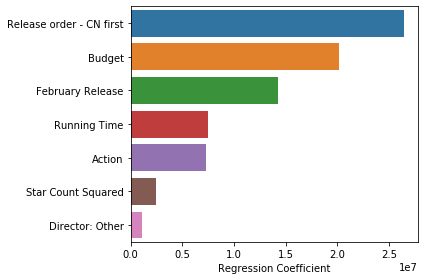

In [192]:
# feature strength - coef size 

features_sorted = list(sorted_coef_dict.keys())
coefs_sorted = list(sorted_coef_dict.values())


sns.barplot(coefs_sorted, features_sorted)
#plt.suptitle('Model Feature Strength')
plt.xlabel('Regression Coefficient')

plt.yticks(range(7) ,['Release order - CN first', 'Budget', 'February Release', 'Running Time', 'Action', 'Star Count Squared', 'Director: Other'])

plt.tight_layout()

plt.savefig('viz/coefs1.svg')

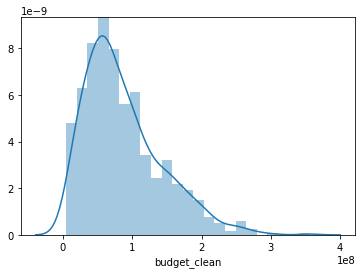

In [164]:
# budget dist

sns.distplot(model_df_all.budget_clean)

''

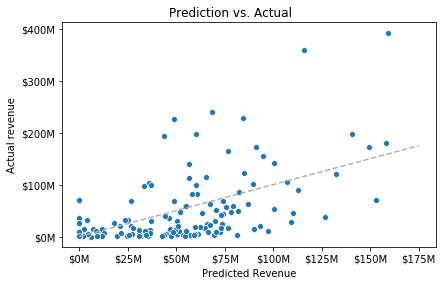

In [193]:
# prediction vs actual

fig, ax = plt.subplots()

sns.scatterplot(test_set_pred_clipped1, y_holdout1)
plt.xlabel('Predicted Revenue')
plt.ylabel('Actual revenue')
ax.plot(np.linspace(0,175000000,2), np.linspace(0,175000000,2), ls="--", c=".7")
plt.tight_layout()
plt.suptitle('Prediction vs. Actual')
plt.xticks(np.linspace(0,175000000,8), ['$0M', '$25M','$50M','$75M','$100M', '$125M', '$150M', '$175M'])
plt.yticks(np.linspace(0,400000000,5), ['$0M','$100M','$200M','$300M','$400M'])
plt.savefig('viz/predicted_vs_actual_rev.svg')
;


''

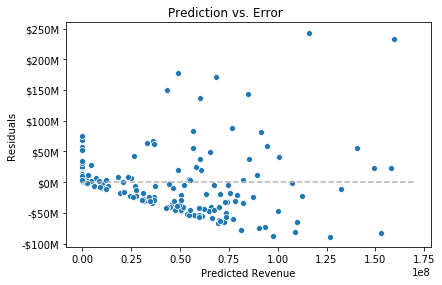

In [194]:
# prediction vs error

res1 = y_holdout1 - test_set_pred1
sns.scatterplot(test_set_pred_clipped1, res1)


plt.xlabel('Predicted Revenue')
plt.ylabel('Residuals')
plt.tight_layout()

xs = np.linspace(0,170000000,2)
horiz_line_data = np.array([40 for i in range(len(xs))])
plt.plot(xs, horiz_line_data, ls="--", c=".7") 

#plt.xticks(np.linspace(0,170000000,8), ['$0M','25M','$50M','$75M','$100M','$125M','15M','$175M'])
plt.yticks(np.linspace(-100000000,250000000,8), ['-$100M','-$50M','$0M','$50M','$100M', '$150M', '$200M', '$250M'])
plt.suptitle('Prediction vs. Error')
plt.savefig('viz/residuals_vs_predicted_rev.svg')
;


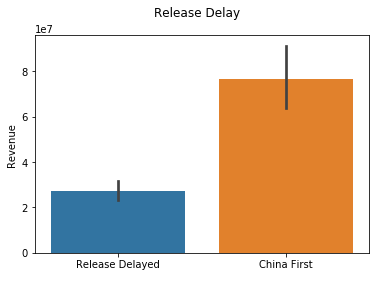

In [195]:
# release timing

sns.barplot(model_df_all.release_order_CN_first, model_df_all.china_total_gross)
plt.xticks(range(2), ['Release Delayed', 'China First'])
plt.xlabel(' ')
plt.ylabel('Revenue')
plt.suptitle("Release Delay")
plt.savefig('viz/release_order.svg')

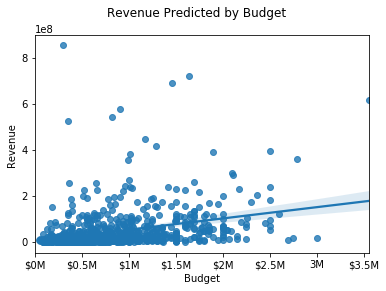

In [196]:


sns.regplot(model_df_all.budget_clean, model_df_all.china_total_gross)
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.suptitle("Revenue Predicted by Budget")
plt.xticks(np.linspace(0,350000000,8), ['$0M','$0.5M','$1M','$1.5M','$2M','$2.5M','3M','$3.5M'])
plt.savefig('viz/budget.svg');

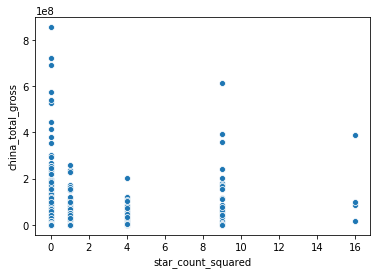

In [169]:
# star_count_squared vs revenue

sns.scatterplot(model_df_all.star_count_squared, model_df_all.china_total_gross)

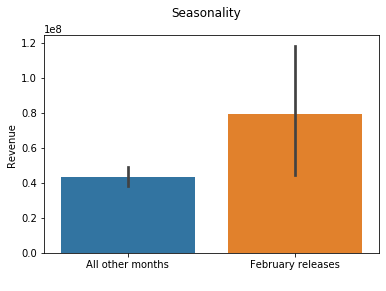

In [197]:
sns.barplot(model_df_all['release_month_2.0'], model_df_all.china_total_gross)
plt.xticks(range(2), ['All other months', 'February releases'])
plt.xlabel(' ')
plt.ylabel('Revenue')
plt.suptitle('Seasonality')
plt.savefig('viz/feb.svg')

''

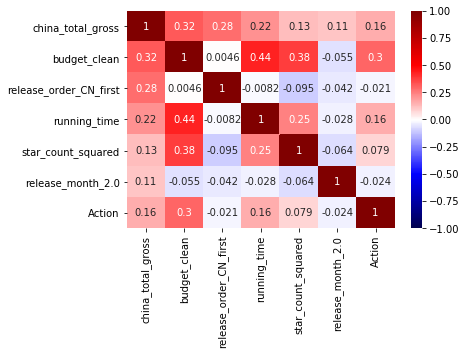

In [199]:
sns.heatmap(model_df_all[[ 
             'china_total_gross','budget_clean',
                        #'director_Other', 
                        #'release_date_diff',
                        'release_order_CN_first',
                        'running_time',
                        #'star_count',
                        'star_count_squared',
                        #'star_power_sum', 
                        #'mpaa_G', 
                        # 'mpaa_NC-17', 
                        #'mpaa_Not Rated', 
                        #'mpaa_PG', 
                        #'mpaa_PG-13',
                        #'mpaa_R',
                        'release_month_2.0', 
                        'Action']].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)
plt.savefig('viz/correlation.svg')
;